In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math as math
import scipy.integrate as integrate
from scipy.interpolate import griddata
from scipy import special
from matplotlib import cm
import emcee

In [2]:
x = np.linspace(0, 10000, 1001) 
y = np.linspace(0, 10000, 1001)
z = np.linspace(0, 10000, 1001)

R = np.sqrt(x**2 + y**2)
r = np.sqrt(x**2 + y**2 + z**2)

#MSP density distributions:

sigma_r = 4500 #pc (average of sigma_r from models in Ploeg et al., Table 2.3)
z_0 = 710 #pc (average of z_0 from models in Ploeg et al., Table 2.3)
N_disk = 6000 #number of pulsars in MW disk, most conservative estimate from Yuan et al. (2014)

#density distribution for MW disk, R^2 = x^2 + y^2 (radial coordinate in Galactic disk), z is height above
#galactic plane, sigma_r and z_0 are parameters:
rho_disk_0 = (N_disk*1.99*10**30)/(4*math.pi*(sigma_r**2)*z_0)
rho_disk = rho_disk_0*(np.exp((-R**2)/(2*(sigma_r**2)))*np.exp(-abs(z)/z_0))

r_0 = 0.22 #pc
rho_0_NSC = 3.3*10**6 #M_sun pc^-3
rho_1_NSC = 8.9*10**7 #M_sun pc^-3 (set so that rho_NSC is continuous at r = 6 pc)

#density distribution for NSC, r^2 = x^2 + y^2 + z^2:
def rho_NSC(R, z, r_0, rho_0_NSC, rho_1_NSC): 
    r = np.sqrt(R**2 + z**2)
    if 6 >= r:
        return (rho_0_NSC)/(1 + (R**2 + z**2)/(r_0**2))
    elif 6 < r <= 200:
        return (rho_1_NSC)/(1 + ((np.sqrt(R**2 + z**2))/r_0)**3)
    elif r > 200:
        return 0.0

#python has a stroke if you don't vectorize things (becuase functions can't take arrays
#as inputs normally)
vrho_NSC = np.vectorize(rho_NSC)
rho_NSC = vrho_NSC(R, z, r_0, rho_0_NSC, rho_1_NSC)

rho_0_NSD = 301 #M_sun pc^-3
rho_1_NSD = 3.53*10**9 #set so that rho_NSD is continuous at r = 120 pc
rho_2_NSD = 5.94*10**24 #set so that rho_NSD is continuous at r = 220 pc

#density distribution for NSD:
def rho_NSD(R, z, rho_0_NSD, rho_1_NSD, rho_2_NSD):
    r = np.sqrt(R**2 + z**2)
    if r == 0:
        return 0.0
    elif r < 120:
        return rho_0_NSD*(r**(-0.1))*(np.exp(-abs(z)/45))
    elif 120 <= r < 220:
        return rho_1_NSD*(r**(-3.5))*(np.exp(-abs(z)/45))
    elif r>= 220:
        return rho_2_NSD*(r**(-10))*(np.exp(-abs(z)/45))
    
vrho_NSD = np.vectorize(rho_NSD)
rho_NSD = vrho_NSD(R, z, rho_0_NSD, rho_1_NSD, rho_2_NSD)

#density distribution for nuclear bulge
rho_nuclear_bulge = rho_NSC + rho_NSD

In [3]:
#numerical integration of densities to find number of MSPs
rho_disk_0 = (N_disk*1.99*10**30)/(4*math.pi*(sigma_r**2)*z_0)
rho_disk_with_jacobian = lambda R, z, t: rho_disk_0*(np.exp((-R**2)/(2*(sigma_r**2)))*np.exp(-abs(z)/z_0))*R

print("rho_disk:")
print(integrate.tplquad(rho_disk_with_jacobian, 0, 2*math.pi, 0, 5000, 0, 5000)[0]) #theta, z, R

rho_nb_part_1 = lambda R, z, t: R*(rho_0_NSC)/(1 + (R**2 + z**2)/(r_0**2))
rho_nb_part_2 = lambda R, z, t: R*(rho_1_NSC)/(1 + ((np.sqrt(R**2 + z**2))/r_0)**3)
rho_nb_part_3 = lambda R, z, t: R*rho_0_NSD*((R**2 + z**2)**(-0.1))*(np.exp(-abs(z)/45))
rho_nb_part_4 = lambda R, z, t: R*rho_1_NSD*((R**2 + z**2)**(-3.5))*(np.exp(-abs(z)/45))
rho_nb_part_5 = lambda R, z, t: R*rho_2_NSD*((R**2 + z**2)**(-10))*(np.exp(-abs(z)/45))


print(" ")
print("rho_nuclear_bulge:")
print(integrate.tplquad(rho_nb_part_1, 0, 2*math.pi, -math.sqrt(6), math.sqrt(6), lambda R, z: -math.sqrt(6-z**2),
                        lambda R, z: math.sqrt(6-z**2))[0] + integrate.tplquad(rho_nb_part_2, 0, 2*math.pi, 
                        -math.sqrt(6), math.sqrt(6), lambda R, z: math.sqrt(6-z**2), lambda R, z: 
                        math.sqrt(200-z**2))[0] + integrate.tplquad(rho_nb_part_3, 0, 2*math.pi, 
                        -2*math.sqrt(30), -0.009, lambda R, z: -math.sqrt(120-z**2),lambda R, z: 
                        math.sqrt(120-z**2))[0] + integrate.tplquad(rho_nb_part_3, 0, 2*math.pi, 
                        0.009, 2*math.sqrt(30), lambda R, z: -math.sqrt(120-z**2),lambda R, z: 
                        math.sqrt(120-z**2))[0] + integrate.tplquad(rho_nb_part_4, 0, 2*math.pi, 
                        -2*math.sqrt(30), -0.009, lambda R, z: math.sqrt(120-z**2), lambda R, z: 
                        math.sqrt(220-z**2))[0] + integrate.tplquad(rho_nb_part_4, 0, 2*math.pi, 
                        0.009, 2*math.sqrt(30), lambda R, z: math.sqrt(120-z**2), lambda R, z: 
                        math.sqrt(220-z**2))[0] + integrate.tplquad(rho_nb_part_5, 0, 2*math.pi, 
                        -2*math.sqrt(55), -0.009, lambda R, z: math.sqrt(220-z**2), lambda R, z: 
                        math.sqrt(5000-z**2))[0] + integrate.tplquad(rho_nb_part_5, 0, 2*math.pi, 
                        0.009, 2*math.sqrt(55), lambda R, z: math.sqrt(220-z**2), lambda R, z: 
                                                                        math.sqrt(5000-z**2))[0])

rho_disk:
2.7473334868924075e+33
 
rho_nuclear_bulge:
10313640.321691435


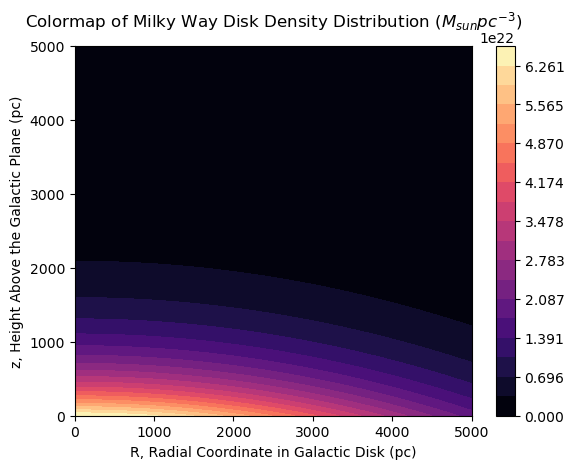

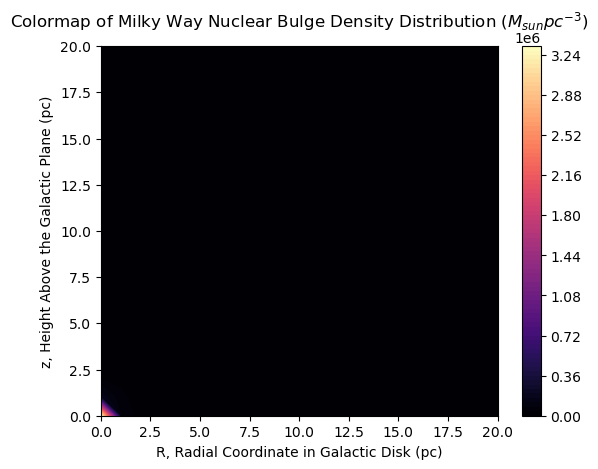

In [4]:
#plot the MSP density distributions to make sure everything seems right
x = np.linspace(0, 5000, 5001) 
y = np.linspace(0, 5000, 5001)
z = np.linspace(0, 5000, 5001)

R = np.sqrt(x**2 + y**2)
r = np.sqrt(x**2 + y**2 + z**2)

#plot the data using np.contourf
R_plot = R
r_plot = r
z_plot = z.reshape(-1, 1)

#rho_disk:
rho_disk_0 = (N_disk*1.99*10**30)/(4*math.pi*(sigma_r**2)*z_0)
rho_disk_plot = rho_disk_0*(np.exp((-R_plot**2)/(2*sigma_r**2))*np.exp(-abs(z_plot)/z_0))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
cont = ax.contourf(rho_disk_plot, cmap=cm.magma, levels = np.linspace(rho_disk.min(), rho_disk.max(), 20).tolist())  
#surf = ax.plot_surface(Rgrid, zgrid, rho_disk_plot)
plt.colorbar(cont)

#print(rho_disk_plot)

plt.title("Colormap of Milky Way Disk Density Distribution ($M_{sun} pc^{-3}$)" , y = 1.03)
plt.xlabel("R, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Plane (pc)")

plt.show()

#rho_nuclear bulge
def rho_NSC_plot(R, z, r_0, rho_0_NSC, rho_1_NSC): 
    r = np.sqrt(R**2 + z**2)
    if 6 >= r:
        return (rho_0_NSC)/(1 + (R**2 + z**2)/(r_0**2))
    elif 6 < r <= 200:
        return (rho_1_NSC)/(1 + ((np.sqrt(R**2 + z**2))/r_0)**3)
    elif r > 200:
        return 0.0
    
def rho_NSD_plot(R, z, rho_0_NSD, rho_1_NSD, rho_2_NSD):
    r = np.sqrt(R**2 + z**2)
    if r == 0:
        return 0.0
    elif r < 120:
        return rho_0_NSD*(r**(-0.1))*(np.exp(-abs(z)/45))
    elif 120 <= r < 220:
        return rho_1_NSD*(r**(-3.5))*(np.exp(-abs(z)/45))
    elif r>= 220:
        return rho_2_NSD*(r**(-10))*(np.exp(-abs(z)/45))
    
vrho_NSD_plot = np.vectorize(rho_NSD_plot)
rho_NSD_plot = vrho_NSD_plot(R_plot, z_plot, rho_0_NSD, rho_1_NSD, rho_2_NSD)
vrho_NSC_plot = np.vectorize(rho_NSC_plot)
rho_NSC_plot = vrho_NSC_plot(R_plot, z_plot, r_0, rho_0_NSC, rho_1_NSC)
rho_nuclear_bulge_plot = rho_NSC_plot + rho_NSD_plot

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cont = ax.contourf(rho_nuclear_bulge_plot, cmap=cm.magma, levels = 100)
plt.colorbar(cont)

plt.ylim(0, 20)
plt.xlim(0, 20)
plt.title("Colormap of Milky Way Nuclear Bulge Density Distribution ($M_{sun} pc^{-3}$)", y = 1.03)
plt.xlabel("R, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Plane (pc)")

plt.show()

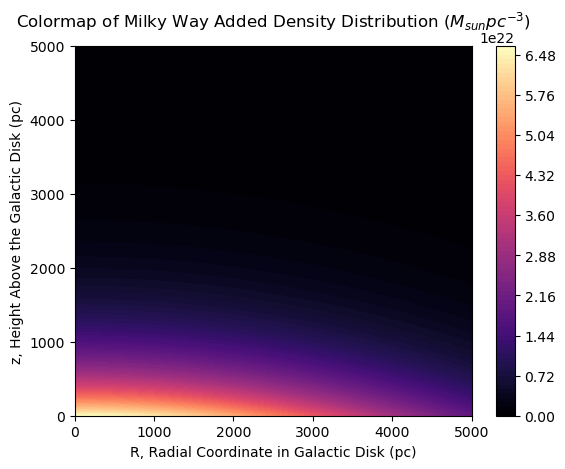

In [5]:
#make a combined plot of all density profiles?
rho_added_plot = (rho_disk_plot + rho_nuclear_bulge_plot)
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cont = ax.contourf(rho_added_plot, cmap=cm.magma, levels = 100)
plt.colorbar(cont)

#plt.xlim(0, 20)
#plt.ylim(0, 20)

plt.title("Colormap of Milky Way Added Density Distribution ($M_{sun} pc^{-3}$)", y = 1.03)
plt.xlabel("R, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Disk (pc)")

plt.show()

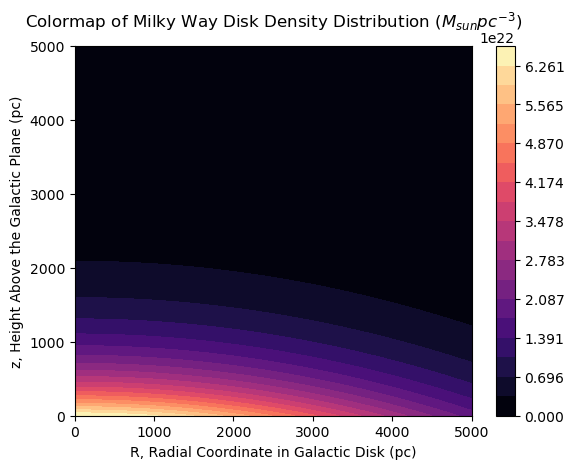

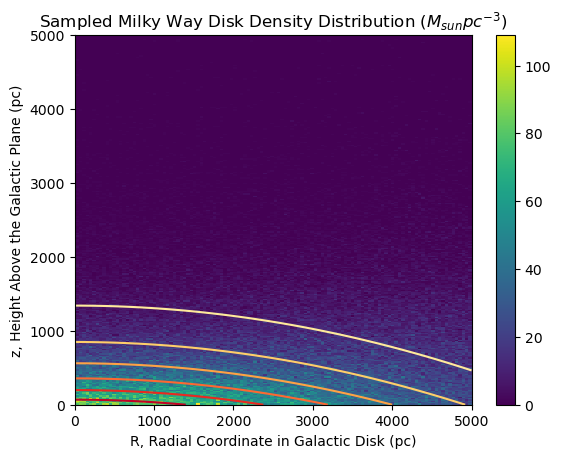

In [6]:
#try MCMC sampling on the conditional probabilities of rho_disk
#plot the test function
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
cont = ax.contourf(rho_disk_plot, cmap=cm.magma, levels = np.linspace(rho_disk.min(), rho_disk.max(), 20).tolist())  
plt.colorbar(cont)

plt.title("Colormap of Milky Way Disk Density Distribution ($M_{sun} pc^{-3}$)" , y = 1.03)
plt.xlabel("R, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Plane (pc)")
plt.show()

#define conditional probabilities
def func_z_bar_R(z, z_0): 
    return np.log((np.exp(-abs(z)/z_0))/(2*z_0))

def func_R_bar_z(R, sigma_r): 
    return np.log((np.exp(-(R**2)/(2*sigma_r**2)))/(2*math.pi*sigma_r))

#try MCMC sampling using emcee
ndim = 1
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

func_z_bar_R_sampler = emcee.EnsembleSampler(nwalkers, ndim, func_z_bar_R, args=[z_0])
func_z_bar_R_state = func_z_bar_R_sampler.run_mcmc(p0, 100)
func_z_bar_R_sampler.reset()

func_z_bar_R_sampler.run_mcmc(func_z_bar_R_state, 40000)

samples1 = func_z_bar_R_sampler.get_chain(flat=True)

func_R_bar_z_sampler = emcee.EnsembleSampler(nwalkers, ndim, func_R_bar_z, args=[sigma_r])
func_R_bar_z_state = func_R_bar_z_sampler.run_mcmc(p0, 100)
func_R_bar_z_sampler.reset()

func_R_bar_z_sampler.run_mcmc(func_R_bar_z_state, 40000)

samples2 = func_R_bar_z_sampler.get_chain(flat=True)
plt.hist2d(samples2[:, 0], samples1[:, 0], bins = 1000) #x = R, y = z
plt.colorbar()

#plot counters of rho_disk to check accuracy of sampling
plt.contour(rho_disk_plot, cmap = "YlOrRd")
plt.title("Sampled Milky Way Disk Density Distribution ($M_{sun} pc^{-3}$)")
plt.xlabel("R, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Plane (pc)")
plt.xlim(0, 5000)
plt.ylim(0, 5000)
#plt.gca().set_yticks([])
plt.show()

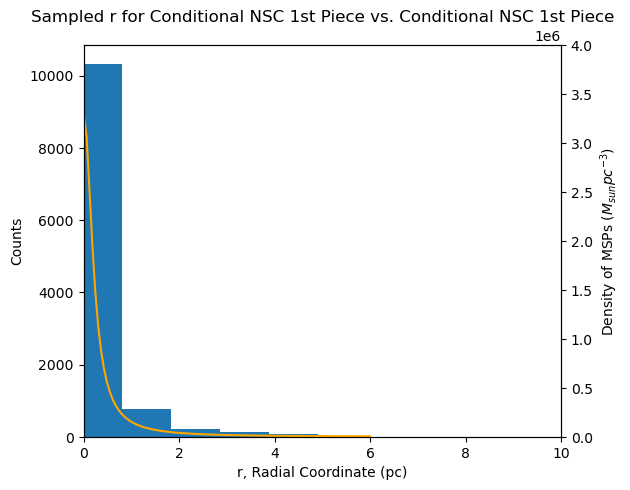

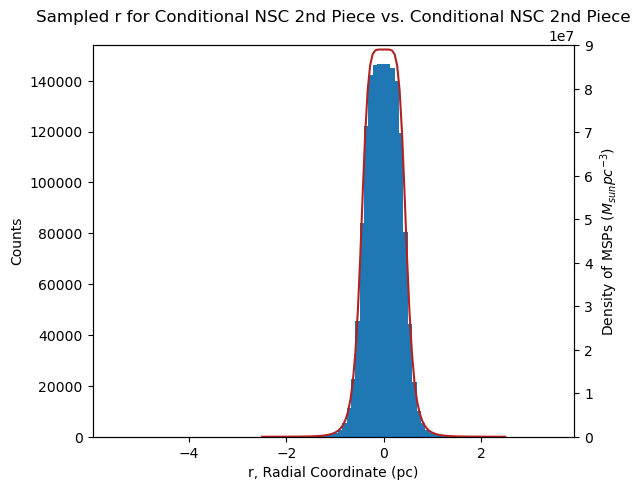

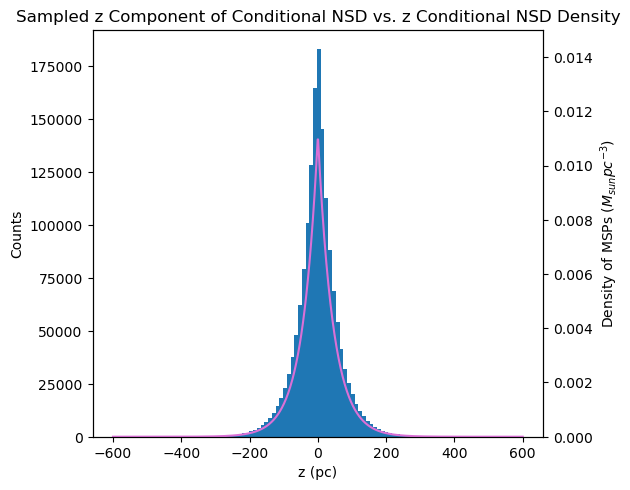

/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_71744/3180941729.py:19: RuntimeWarning: divide by zero encountered in power
  return (0.0121)*(r**(-0.1))


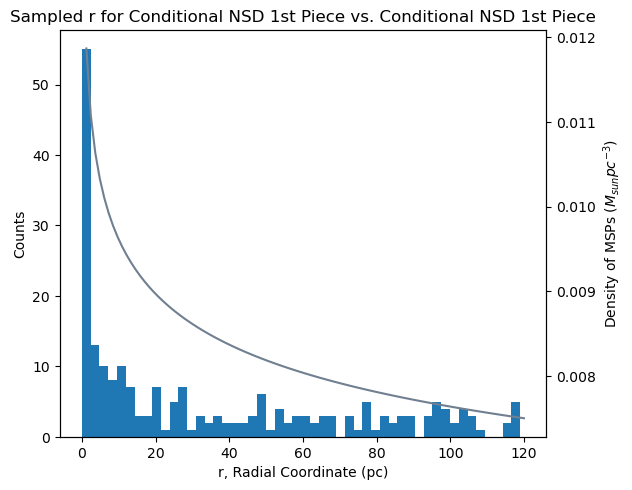

In [7]:
#1D MCMC sample the nuclear bulge population 
def MC_rho_NSC_1(r, r_0, rho_0_NSC, rho_1_NSC):
    if (r <= 6):
        return np.log((rho_0_NSC)/(1 + (r**2)/(r_0**2)))
    else:
        return -np.inf
def MC_rho_NSC_2(r, r_0, rho_0_NSC, rho_1_NSC):
    return np.log((rho_1_NSC)/(1 + ((r**2)/r_0)**3))

#for plotting comparisons
def MC_rho_NSC_1p(r, r_0, rho_0_NSC, rho_1_NSC):
    return (rho_0_NSC)/(1 + (r**2)/(r_0**2))
def MC_rho_NSC_2p(r, r_0, rho_0_NSC, rho_1_NSC):
    return (rho_1_NSC)/(1 + ((r**2)/r_0)**3)

def MC_rho_NSD_zp(z):
    return np.exp(-abs(z)/45)/90
def MC_rho_NSD_r1p(r):
    return (0.0121)*(r**(-0.1))

#sample the NSC part first
ndim = 1
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

MC_rho_NSC_1_sampler = emcee.EnsembleSampler(nwalkers, ndim, MC_rho_NSC_1, args=[r_0, rho_0_NSC, rho_1_NSC])
MC_rho_NSC_1_state = MC_rho_NSC_1_sampler.run_mcmc(p0, 100)
MC_rho_NSC_1_sampler.reset()

MC_rho_NSC_1_sampler.run_mcmc(MC_rho_NSC_1_state, 500)

MC_rho_NSC_2_sampler = emcee.EnsembleSampler(nwalkers, ndim, MC_rho_NSC_2, args=[r_0, rho_0_NSC, rho_1_NSC])
MC_rho_NSC_2_state = MC_rho_NSC_2_sampler.run_mcmc(p0, 100)
MC_rho_NSC_2_sampler.reset()

MC_rho_NSC_2_sampler.run_mcmc(MC_rho_NSC_2_state, 50000)

samples_NSC_1 = MC_rho_NSC_1_sampler.get_chain(flat=True)
samples_NSC_2 = MC_rho_NSC_2_sampler.get_chain(flat=True)

fig, ax1 = plt.subplots()

ax1.hist(samples_NSC_1[:, 0], 500)
ax1.set_xlabel("r, Radial Coordinate (pc)")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(np.linspace(0, 6, 100), MC_rho_NSC_1p(np.linspace(0, 6, 100), r_0, rho_0_NSC, rho_1_NSC), color = "orange")
ax2.set_ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Sampled r for Conditional NSC 1st Piece vs. Conditional NSC 1st Piece")
#plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 4e6)
plt.show()

fig, ax1 = plt.subplots()

ax1.hist(samples_NSC_2[:, 0], 100)
ax1.set_xlabel("r, Radial Coordinate (pc)")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(np.linspace(-2.5, 2.5, 100), MC_rho_NSC_2p(np.linspace(-2.5, 2.5, 100), r_0, rho_0_NSC, rho_1_NSC), color = "firebrick")
ax2.set_ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Sampled r for Conditional NSC 2nd Piece vs. Conditional NSC 2nd Piece")
plt.ylim(0, 9e7)
#plt.legend()
plt.show()

#do a wierd r and z 2D sampling
def MC_rho_NSD_z(z):
    return np.log(np.exp(-abs(z)/45)/90)
def MC_rho_NSD_r1(r):
    if (0 < r < 120):
        return np.log((0.0121)*(r**(-0.1)))
    else:
        return -np.inf

#now the NSD part, sample in both r and z
ndim = 1
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

MC_rho_NSD_z_sampler = emcee.EnsembleSampler(nwalkers, ndim, MC_rho_NSD_z)
MC_rho_NSD_z_state = MC_rho_NSD_z_sampler.run_mcmc(p0, 100)
MC_rho_NSD_z_sampler.reset()

MC_rho_NSD_z_sampler.run_mcmc(MC_rho_NSD_z_state, 50000)
samples_NSD_z = MC_rho_NSD_z_sampler.get_chain(flat=True)

MC_rho_NSD_r1_sampler = emcee.EnsembleSampler(nwalkers, ndim, MC_rho_NSD_r1)
MC_rho_NSD_r1_state = MC_rho_NSD_r1_sampler.run_mcmc(p0, 50)
MC_rho_NSD_r1_sampler.reset()

MC_rho_NSD_r1_sampler.run_mcmc(MC_rho_NSD_r1_state, 7)

samples_NSD_r1 = MC_rho_NSD_r1_sampler.get_chain(flat=True)

fig, ax1 = plt.subplots()

ax1.hist(samples_NSD_z[:, 0], 100)
ax1.set_xlabel("z (pc)")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(np.linspace(-600, 600, 1000), MC_rho_NSD_zp(np.linspace(-600, 600, 1000)), color = "orchid")
ax2.set_ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Sampled z Component of Conditional NSD vs. z Conditional NSD Density")
plt.ylim(0, 0.015)
#plt.legend()
plt.show()

fig, ax1 = plt.subplots()

ax1.hist(samples_NSD_r1[:, 0], 50)
ax1.set_xlabel("r, Radial Coordinate (pc)")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(np.linspace(0, 120, 100), MC_rho_NSD_r1p(np.linspace(0, 120, 100)), color = "slategray")
ax2.set_ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Sampled r for Conditional NSD 1st Piece vs. Conditional NSD 1st Piece")
#plt.legend()
plt.show()

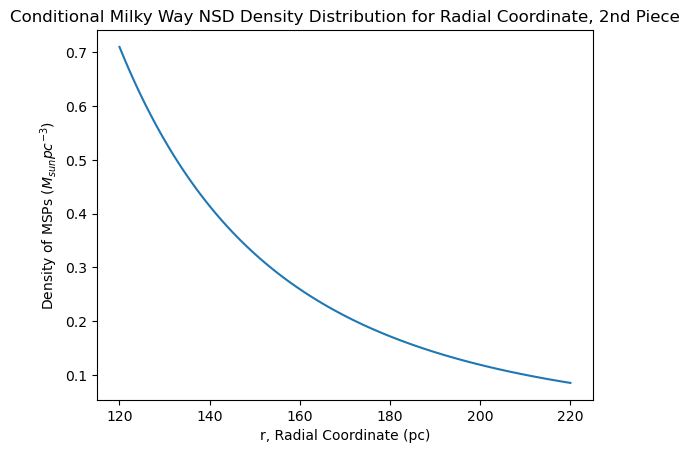

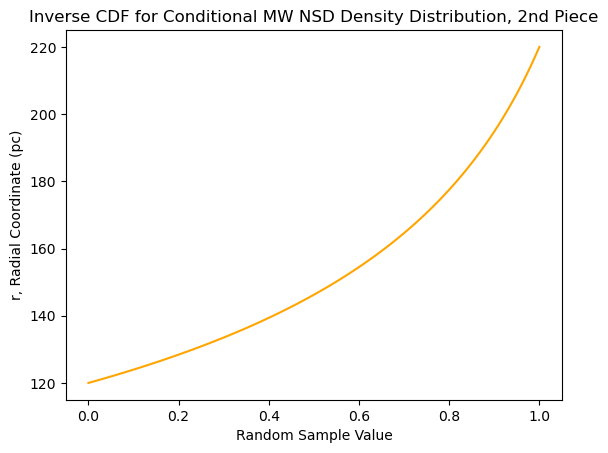

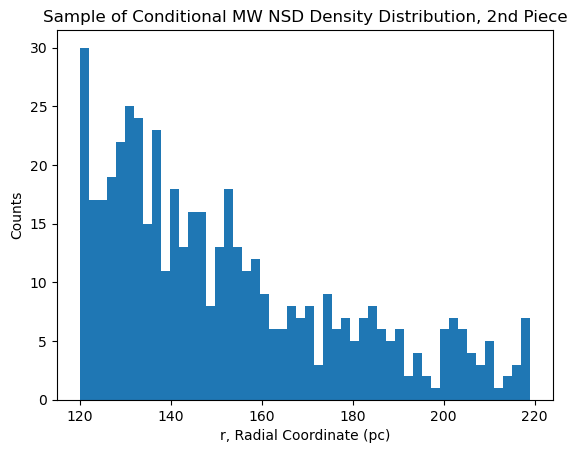

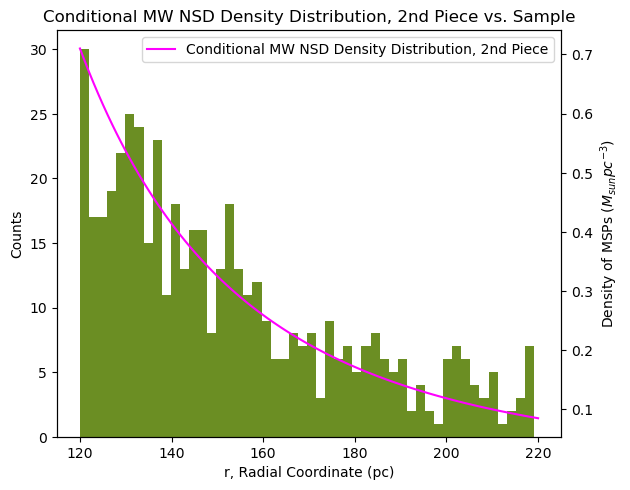

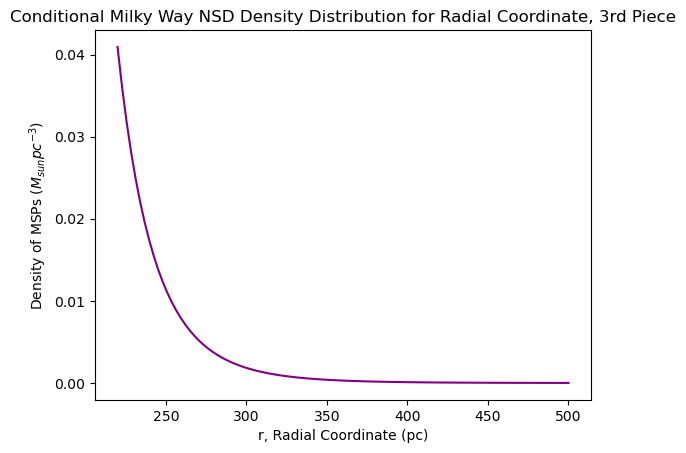

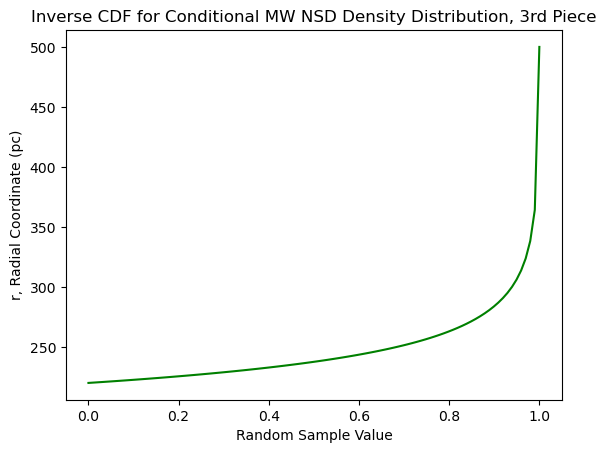

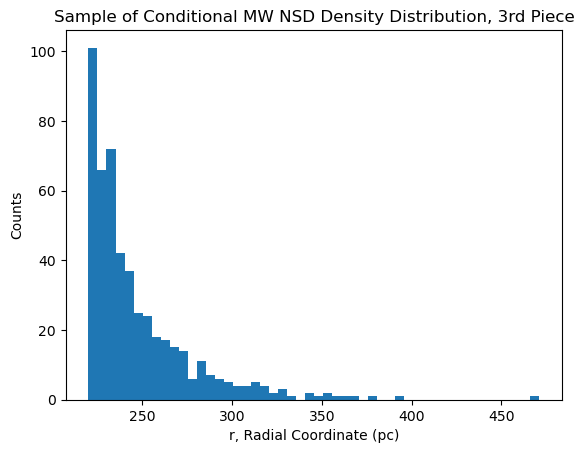

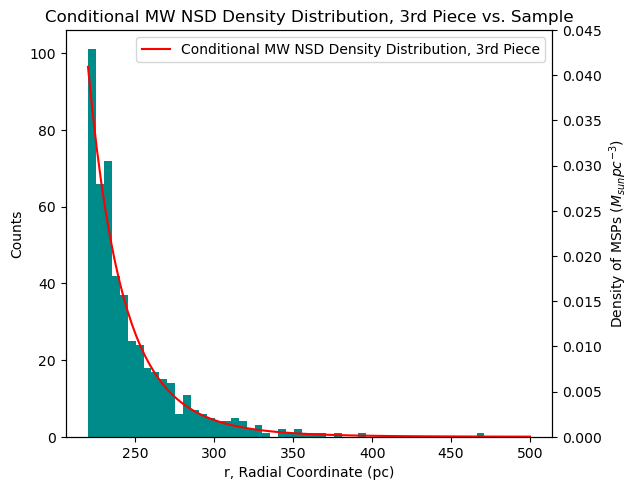

In [10]:
#inverse transform sampling on two later NSD functions, b/c the MCMC sampler was getting stuck
#sample the NSD 2nd piece (in the form of a power law)
def NSD_2_piece(r, a, c):
    return c*r**(-a)

plt.plot(np.linspace(120, 220, 101), NSD_2_piece(np.linspace(120, 220, 101), 3.5, 1.344*10**7))
plt.title("Conditional Milky Way NSD Density Distribution for Radial Coordinate, 2nd Piece")
plt.xlabel("r, Radial Coordinate (pc)")
plt.ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
plt.show()

#inverse CDF given by a specific power function related form of the inv_cdf
def inv_cdf2(x, a):
    return ((220**(1-a) - 120**(1-a))*x + 120**(1-a))**(1/(1-a))

plt.plot(np.linspace(0, 1, 100), inv_cdf2(np.linspace(0, 1, 100), 3.5), color = "orange")
plt.title("Inverse CDF for Conditional MW NSD Density Distribution, 2nd Piece")
plt.xlabel("Random Sample Value")
plt.ylabel("r, Radial Coordinate (pc)")
plt.show()

#generate a random sample using inverse CDF
sample = np.random.rand(500)
plt.hist(inv_cdf2(sample, 3.5), 50)
plt.title("Sample of Conditional MW NSD Density Distribution, 2nd Piece")
plt.xlabel("r, Radial Coordinate (pc)")
plt.ylabel("Counts")
plt.show()

#plot both on top of eachother to see the accuracy
fig, ax1 = plt.subplots()

ax1.hist(inv_cdf2(sample, 3.5), 50, color = "olivedrab")
ax1.set_xlabel("r, Radial Coordinate (pc)")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(np.linspace(120, 220, 101), NSD_2_piece(np.linspace(120, 220, 101), 3.5, 1.344*10**7), color = "magenta", label = "Conditional MW NSD Density Distribution, 2nd Piece")
ax2.set_ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Conditional MW NSD Density Distribution, 2nd Piece vs. Sample")
plt.legend()
plt.show()

#sample the NSD 3rd piece
def NSD_3_piece(r, a, c):
    return c*r**(-a)

plt.plot(np.linspace(220, 500, 101), NSD_3_piece(np.linspace(220, 500, 101), 10, 1.087*10**22), color = "purple")
plt.title("Conditional Milky Way NSD Density Distribution for Radial Coordinate, 3rd Piece")
plt.xlabel("r, Radial Coordinate (pc)")
plt.ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
plt.show()

#inverse CDF given by a specific power function realted form of the inv_cdf
def inv_cdf3(x, a):
    return ((500**(1-a) - 220**(1-a))*x + 220**(1-a))**(1/(1-a))

plt.plot(np.linspace(0, 1, 100), inv_cdf3(np.linspace(0, 1, 100), 10), color = "green")
plt.title("Inverse CDF for Conditional MW NSD Density Distribution, 3rd Piece")
plt.xlabel("Random Sample Value")
plt.ylabel("r, Radial Coordinate (pc)")
plt.show()

#generate a random sample using inverse CDF
sample = np.random.rand(500)
plt.hist(inv_cdf3(sample, 10), 50)
plt.title("Sample of Conditional MW NSD Density Distribution, 3rd Piece")
plt.xlabel("r, Radial Coordinate (pc)")
plt.ylabel("Counts")
plt.show()

#plot both on top of eachother to see the accuracy
fig, ax1 = plt.subplots()

ax1.hist(inv_cdf3(sample, 10), 50, label = "Sample", color = "darkcyan")
ax1.set_xlabel("r, Radial Coordinate (pc)")
ax1.set_ylabel("Counts")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(np.linspace(220, 500, 101), NSD_3_piece(np.linspace(220, 500, 101), 10, 1.087*10**22), color = "red", label = "Conditional MW NSD Density Distribution, 3rd Piece")
ax2.set_ylabel("Density of MSPs ($M_{sun} pc^{-3}$)")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Conditional MW NSD Density Distribution, 3rd Piece vs. Sample")
ax2.set_ylim(0, 0.045)
plt.legend()
plt.show()

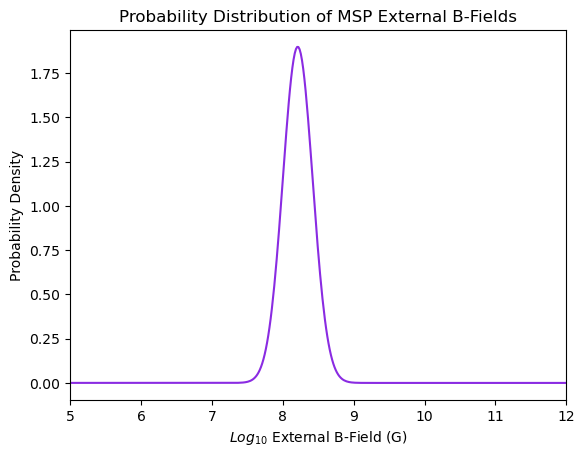

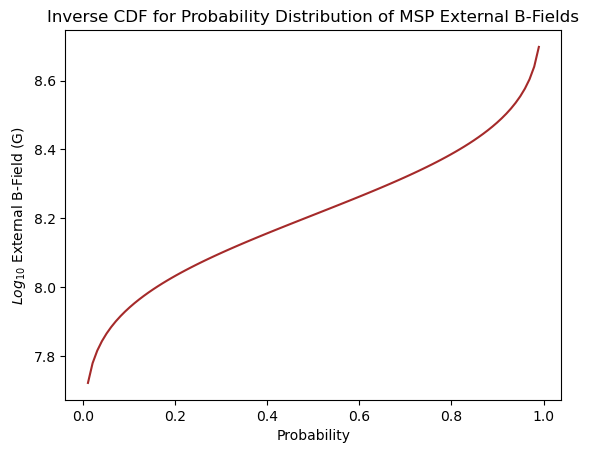

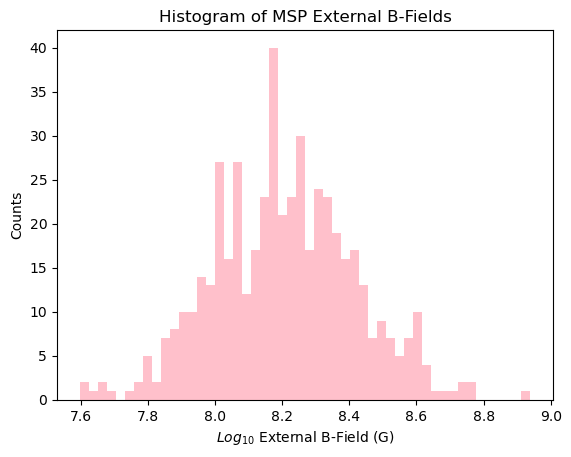

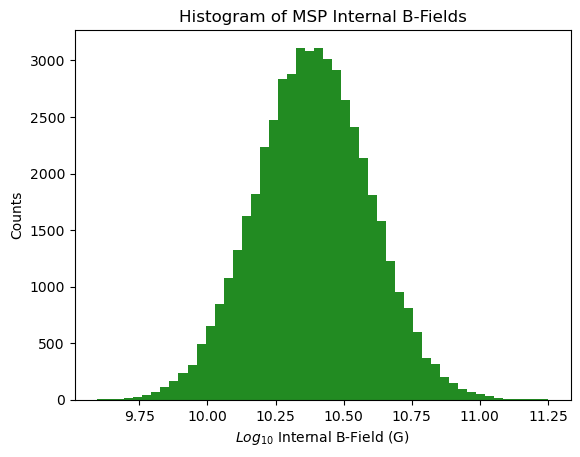

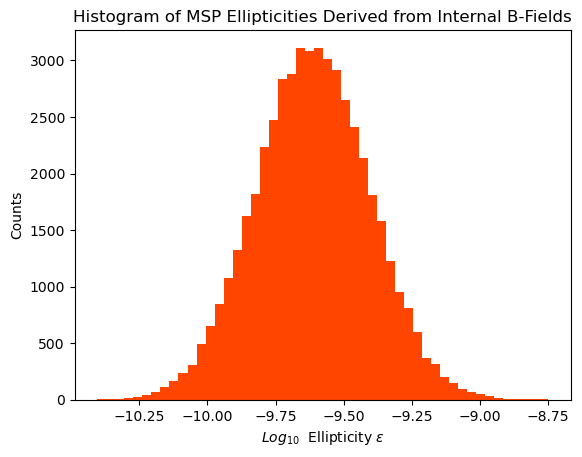

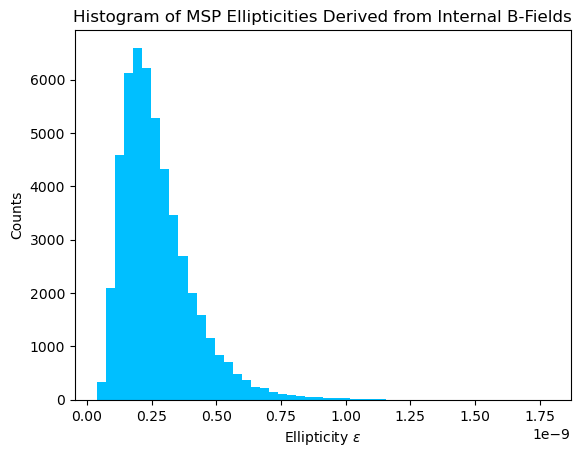

In [9]:
#plot the moment of inertia (ellipticity?) distribution for MSPs

#to find the ellipticity distribution, Miller et al. uses two methods. We'll adopt the 1st:
#assume the deformations are caused by the internal magnetic field

#averages of log10(B_med) and sigma_B from Ploeg et al., which is a fairly different range than
#what Miller et al. has for their B-fields
log_10_B_med = 8.21 #B_med in G 
sigma_B = 0.21 

#we have to inverse transform sample this to get a distribution of B fields
def p_B(log_10_B, sigma_B, log_10_B_med): 
    return (1/((np.sqrt(2*np.pi)*sigma_B)))*np.exp(-((log_10_B - log_10_B_med)**2)/(2*(sigma_B**2)))

plt.plot(np.linspace(0, 17, 1000), p_B(np.linspace(0, 17, 1000), sigma_B, log_10_B_med), color = "blueviolet")
plt.title("Probability Distribution of MSP External B-Fields")
plt.xlabel("$Log_{10}$ External B-Field (G)")
plt.ylabel("Probability Density")
plt.xlim(5, 12)
plt.show()

def inv_cdf_p_B(log_10_B, sigma_B, log_10_B_med):
    return log_10_B_med - math.sqrt(2)*sigma_B*special.erfinv(-2*log_10_B + 1)

plt.plot(np.linspace(0, 1, 100), inv_cdf_p_B(np.linspace(0, 1, 100), sigma_B, log_10_B_med), color = "brown")
plt.title("Inverse CDF for Probability Distribution of MSP External B-Fields")
plt.ylabel("$Log_{10}$ External B-Field (G)")
plt.xlabel("Probability")
plt.show()

#sample the distribution
sample = np.random.rand(500)
plt.hist(inv_cdf_p_B(sample, sigma_B, log_10_B_med), 50, color = "pink")
plt.title("Histogram of MSP External B-Fields")
plt.xlabel("$Log_{10}$ External B-Field (G)")
plt.ylabel("Counts")
plt.show()

#so B_ext is:
sample = np.random.rand(50000)
B_log_ext = inv_cdf_p_B(sample, sigma_B, log_10_B_med)
B_ext = 10**B_log_ext

#according to Miller et al. B_int = 150*B_ext (conservatively, could be up to 10^4 times greater):
#try 150, 1000, 10,000 times to see if conincides with min. ellipticity of 10^-9 from Woan, etc.?
B_int = 150*B_ext

plt.hist(np.log10(B_int), 50, color = "forestgreen")
plt.title("Histogram of MSP Internal B-Fields")
plt.xlabel("$Log_{10}$ Internal B-Field (G)")
plt.ylabel("Counts")
plt.show()

#ellipticity is then given by 10^-8*(b_int*(10^-12)), or in log scale:
rescaled_B_int = B_int/(10**12)
epsilon_B = (10**-8)*rescaled_B_int

#find the log10(ellipticity):
epsilon_log = np.log10(epsilon_B)

#plot log10(ellipticity)
plt.hist(epsilon_log, 50, color = "orangered")
plt.title("Histogram of MSP Ellipticities Derived from Internal B-Fields")
plt.xlabel("$Log_{10}$  Ellipticity $\epsilon$")
plt.ylabel("Counts")
plt.show()

#plot regular ellipticity
plt.hist(epsilon_B, 50, color = "deepskyblue")
plt.title("Histogram of MSP Ellipticities Derived from Internal B-Fields")
plt.xlabel("Ellipticity $\epsilon$")
plt.ylabel("Counts")
plt.show()

In [10]:
#convert the MW nuclear bulge population from r (defined as r^2 = x^2 + y^2 + z^2
#or r^2 = R^2 + z^2) and z coords. to R and z coords

#the NSC population only depends on r --> we'll have to generate a random sample 
#of z values in a certain range and solve for R

#from the nuclear bulge plot, it looks as though z dies off before 5 kpc
NSC_sample_z_1 = np.random.randint(0, 5, 1000)
NSC_sample_z_2 = np.random.randint(0, 5, 1000)

NSC_1_sample_r = np.random.choice(samples_NSC_1[:, 0], size = 1000)
NSC_2_sample_r = np.random.choice(samples_NSC_2[:, 0], size = 1000)

NSC_1_sample_R = np.sqrt(NSC_1_sample_r**2 - NSC_sample_z_1**2)[~np.isnan((np.sqrt(NSC_1_sample_r**2 - NSC_sample_z_1**2)))]
NSC_2_sample_R = np.sqrt(NSC_2_sample_r**2 - NSC_2_sample_r**2)[~np.isnan((np.sqrt(NSC_2_sample_r**2 - NSC_2_sample_r**2)))]

NSC_size = NSC_1_sample_R.size + NSC_2_sample_R.size
#print(NSC_size)

#the NSD population has r and z dependence --> use the sampled z component to solve for R
NSD_z_1_sample = np.random.choice(samples_NSD_z[:, 0], size = 500)
NSD_z_2_sample = np.random.choice(samples_NSD_z[:, 0], size = 500)
NSD_z_3_sample = np.random.choice(samples_NSD_z[:, 0], size = 500)

NSD_1_sample_r = np.random.choice(samples_NSD_r1[:, 0], size = 500)
NSD_2_sample_r = np.random.choice(inv_cdf2(sample, 3.5), size = 500) 
NSD_3_sample_r = np.random.choice(inv_cdf3(sample, 10), size = 500) 

NSD_1_sample_R = np.sqrt(NSD_1_sample_r**2 - NSD_z_1_sample**2)[~np.isnan(np.sqrt(NSD_1_sample_r**2 - NSD_z_1_sample**2))]
NSD_2_sample_R = np.sqrt(NSD_2_sample_r**2 - NSD_z_2_sample**2)[~np.isnan(np.sqrt(NSD_2_sample_r**2 - NSD_z_2_sample**2))]
NSD_3_sample_R = np.sqrt(NSD_3_sample_r**2 - NSD_z_3_sample**2)[~np.isnan(np.sqrt(NSD_3_sample_r**2 - NSD_z_3_sample**2))]

NSD_size = NSD_1_sample_R.size + NSD_2_sample_R.size + NSD_3_sample_R.size
#print(NSD_size)

NB_size = NSC_size + NSD_size
print(NB_size)

#find the new MW disk population R and z values
#assume best sample size is in range of 36,000 - 47,000 (say 40,000 total) from Hooper et al.
MWD_size = 40000 - NB_size
print(MWD_size)

MWD_R = np.random.choice(samples2[:, 0], size = MWD_size)
MWD_z = np.random.choice(samples1[:, 0], size = MWD_size)

R = np.concatenate((MWD_R, NSC_1_sample_R, NSC_2_sample_R, NSD_1_sample_R, NSD_2_sample_R, NSD_3_sample_R))
z = np.concatenate((MWD_z, NSC_sample_z_1[~np.isnan((np.sqrt(NSC_1_sample_r**2 - NSC_sample_z_1**2)))], 
                    NSC_sample_z_2[~np.isnan((np.sqrt(NSC_2_sample_r**2 - NSC_2_sample_r**2)))], 
                    NSD_z_1_sample[~np.isnan(np.sqrt(NSD_1_sample_r**2 - NSD_z_1_sample**2))], 
                    NSD_z_2_sample[~np.isnan(np.sqrt(NSD_2_sample_r**2 - NSD_z_2_sample**2))], 
                    NSD_z_3_sample[~np.isnan(np.sqrt(NSD_3_sample_r**2 - NSD_z_3_sample**2))]))

print(R.size)
print(z.size)

2401
37599
40000
40000


/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_62096/3195548936.py:14: RuntimeWarning: invalid value encountered in sqrt
  NSC_1_sample_R = np.sqrt(NSC_1_sample_r**2 - NSC_sample_z_1**2)[~np.isnan((np.sqrt(NSC_1_sample_r**2 - NSC_sample_z_1**2)))]
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_62096/3195548936.py:29: RuntimeWarning: invalid value encountered in sqrt
  NSD_1_sample_R = np.sqrt(NSD_1_sample_r**2 - NSD_z_1_sample**2)[~np.isnan(np.sqrt(NSD_1_sample_r**2 - NSD_z_1_sample**2))]
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_62096/3195548936.py:30: RuntimeWarning: invalid value encountered in sqrt
  NSD_2_sample_R = np.sqrt(NSD_2_sample_r**2 - NSD_z_2_sample**2)[~np.isnan(np.sqrt(NSD_2_sample_r**2 - NSD_z_2_sample**2))]
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_62096/3195548936.py:31: RuntimeWarning: invalid value encountered in sqrt
  NSD_3_sample_R = np.sqrt(NSD_3_sample_r**2 - NSD_z_3_sample**2)[~np.isnan(np.sqrt(NSD_3_s

In [11]:
#convert MW disk and bulge pulsar distribution from cylindrical to spherical coordinates
theta1 = np.arctan(z/R) #dec., strange def. but due to the differences between the math/physics convention
init_theta = np.random.choice(theta1[~np.isnan(theta1)], size = 40000)
init_phi = np.random.uniform(-2*math.pi, 2*math.pi, 40000) #RA, drawn from uniform dist. on [0, 2pi]

#convert from ra and dec to galactic?
from astropy import units as u
from astropy.coordinates import SkyCoord

gal = SkyCoord(init_phi[:], init_theta[:], frame='galactic', unit=u.deg)

#find eliipticity
sample = np.random.rand(50000)
B_log_ext = inv_cdf_p_B(sample, sigma_B, log_10_B_med)
B_ext = 10**B_log_ext
B_int = 150*B_ext
rescaled_B_int = B_int/(10**12)
epsilon_B = (10**-8)*rescaled_B_int

/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_62096/1137209149.py:2: RuntimeWarning: divide by zero encountered in divide
  theta1 = np.arctan(z/R) #dec., strange def. but due to the differences between the math/physics convention
/var/folders/0r/2bwbsj0536qfybj3dfw_6v840000gn/T/ipykernel_62096/1137209149.py:2: RuntimeWarning: invalid value encountered in divide
  theta1 = np.arctan(z/R) #dec., strange def. but due to the differences between the math/physics convention


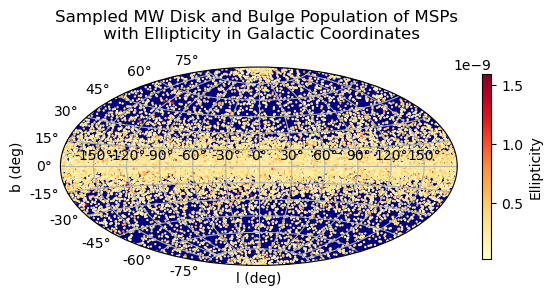

In [12]:
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
a = np.ones([359, 129])
b = np.transpose(a)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('YlOrRd')
ep_rand = np.random.choice(epsilon_B, size = 40000)

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(init_phi, init_theta, c = ep_rand, s = 0.5, cmap = 'YlOrRd')

cb = plt.colorbar(sc, label = "Ellipticity", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with Ellipticity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

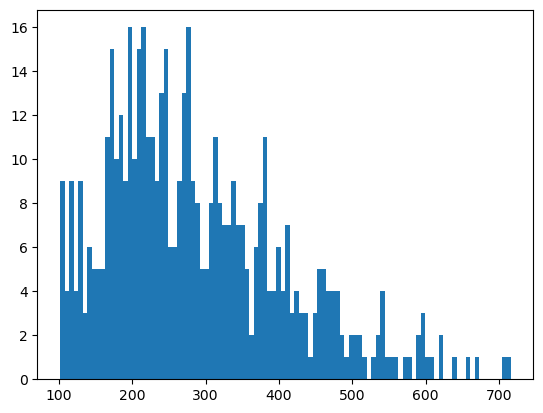

288.2443907316967
121.36792366842593


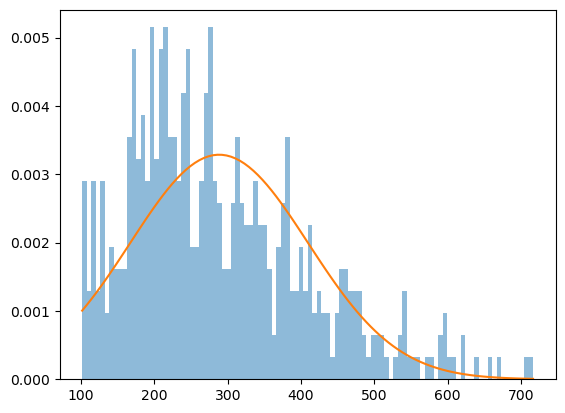

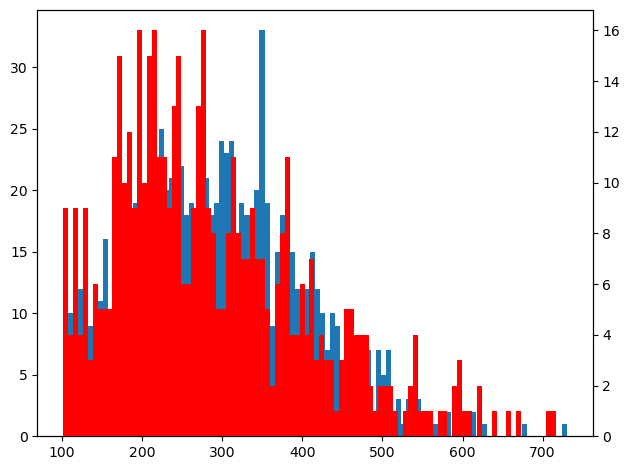

In [13]:
#to find the GW signal, we need to find the rotational frequency distribution
#need to query the ATNF database
from psrqpy import QueryATNF
import scipy
freq_query = QueryATNF(params=['F0'], condition = 'P0 < 0.01')

freq_df = freq_query.dataframe
freq_array = freq_df.to_numpy().flatten()[~np.isnan(freq_df.to_numpy().flatten())]
#print(freq_array.size) #is 855
#print(freq_array)

#frequency comes in 2 populations: high and low
high_freq_array = freq_array[freq_array > 100]

plt.hist(high_freq_array, 100)
plt.show()

#we only have 855 MSPs from the ATNF catalgoue with F0 data --> need to create a distribution
#look at just the high freq. array to begin b/c the low one is strange
_, bins, _ = plt.hist(high_freq_array, 100, density=1, alpha=0.5)
mu, sigma = scipy.stats.norm.fit(high_freq_array)

#find mu and sigma
print(mu)
print(sigma)

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.show()

#create distribution
high_freq_dist = np.random.normal(mu, sigma, 1000)
fig, ax1 = plt.subplots()

ax1.hist(high_freq_dist[high_freq_dist > 100], bins = 100)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#ax2.plot(best_fit_line, color = "red")
ax2.hist(high_freq_array, 100, color = "red")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#now generate a sample of 40000
norm_freq_sample = np.random.normal(mu, sigma, 50000)
freq_sample = np.random.choice(norm_freq_sample[norm_freq_sample >= 100], 40000)

39806


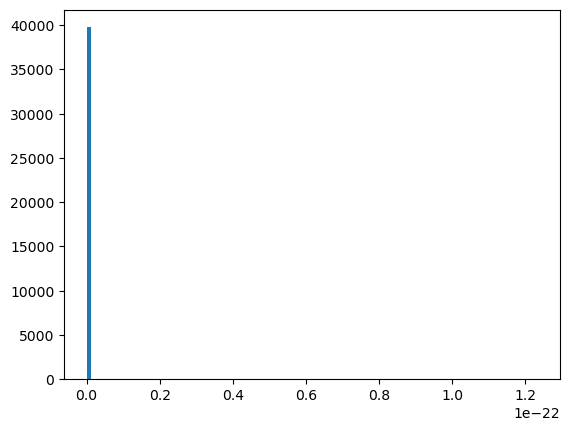

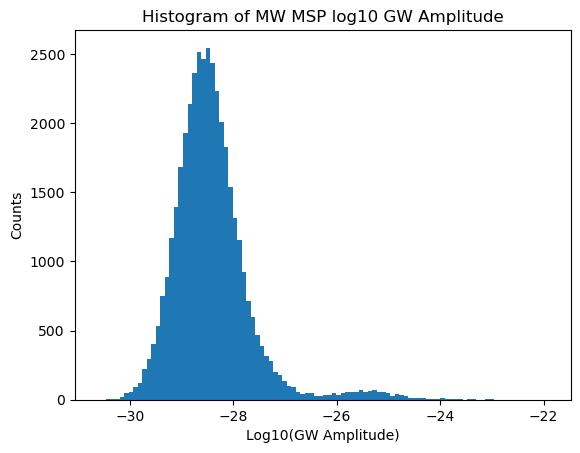

In [14]:
#calculate the GW signal distribution based off of the ellipticity distribution
#we need the distance to the the pulsar from Earth (start by approximating as dist. to Sun)
dist = np.sqrt(z**2 + R**2)

#the equation for the GW amplitude from Miller et al.:
#assuming I_zz ~ 10^38, could also be 5*10^38, 10^39 kg/m^2
init_A_GW = (16*(math.pi**2)*(6.67e-11)*(10**38)*ep_rand*(freq_sample**2))/(((3e8)**4)*dist*3.086e16)

A_GW = init_A_GW[np.isfinite(init_A_GW)]

#to ensure that we still have a connection between dist. and GW amplitude
theta = init_theta[np.isfinite(init_A_GW)]
phi = init_phi[np.isfinite(init_A_GW)]

print(phi.size)

plt.hist(A_GW, bins = 100)
#plt.xlim(0, 0.2e10)
plt.show()

plt.hist(np.log10(A_GW), bins = 100)
plt.title("Histogram of MW MSP log10 GW Amplitude")
plt.ylabel("Counts")
plt.xlabel("Log10(GW Amplitude)")
plt.show()

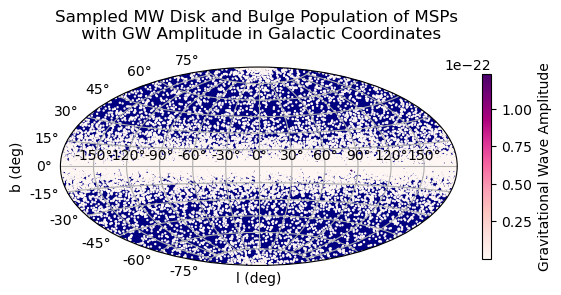

In [15]:
#make a similar 2D plot as the ellipticity one but with the GW amplitude instead
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
a = np.ones([359, 129])
b = np.transpose(a)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('RdPu')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(phi, theta, c = A_GW, s = 0.5, cmap = 'RdPu')

cb = plt.colorbar(sc, label = "Gravitational Wave Amplitude", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with GW Amplitude in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

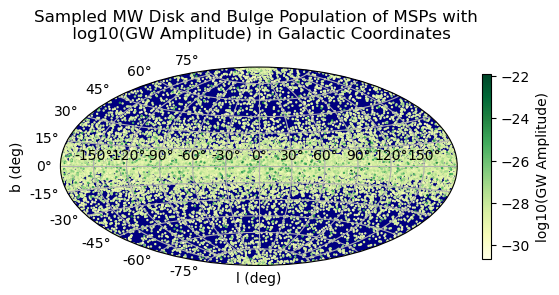

In [16]:
#make a similar 2D plot as the ellipticity one but with the GW amplitude instead (log scale version)
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
a = np.ones([359, 129])
b = np.transpose(a)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('RdPu')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(phi, theta, c = np.log10(A_GW), s = 0.5, cmap = 'YlGn')

cb = plt.colorbar(sc, label = "log10(GW Amplitude)", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with \n log10(GW Amplitude) in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

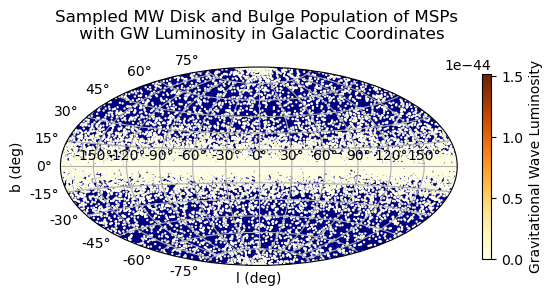

In [17]:
#make a similar 2D plot as the ellipticity one but with the GW luminosity instead
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
a = np.ones([359, 129])
b = np.transpose(a)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('RdPu')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(phi, theta, c = A_GW**2, s = 0.5, cmap = 'YlOrBr')

cb = plt.colorbar(sc, label = "Gravitational Wave Luminosity", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

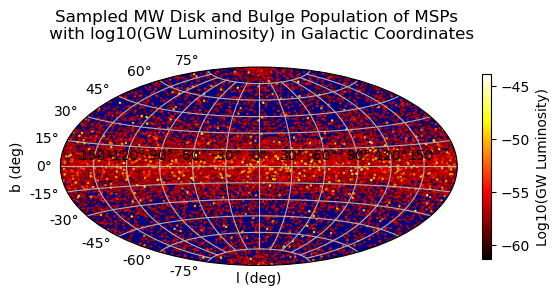

In [18]:
#make a similar 2D plot as the ellipticity one but with the log 10 GW luminosity instead
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
a = np.ones([359, 129])
b = np.transpose(a)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('RdPu')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(phi, theta, c = np.log10(A_GW**2), s = 0.5, cmap = 'hot')

cb = plt.colorbar(sc, label = "Log10(GW Luminosity)", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with log10(GW Luminosity) in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

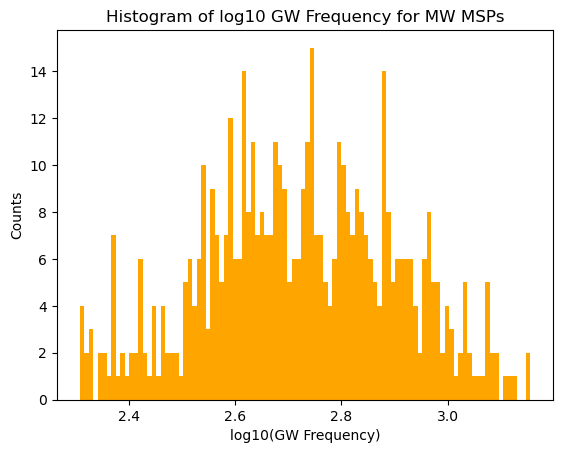

In [19]:
#plot the GW frequency distribution

#from Miller et al.: f_GW = 2f_rot
f_GW = 2*high_freq_array

#plot all distributions
plt.hist(np.log10(f_GW), bins = 100, color = "orange")
plt.title("Histogram of log10 GW Frequency for MW MSPs")
plt.ylabel("Counts")
plt.xlabel("log10(GW Frequency)")
plt.show()

-61.25679038441217


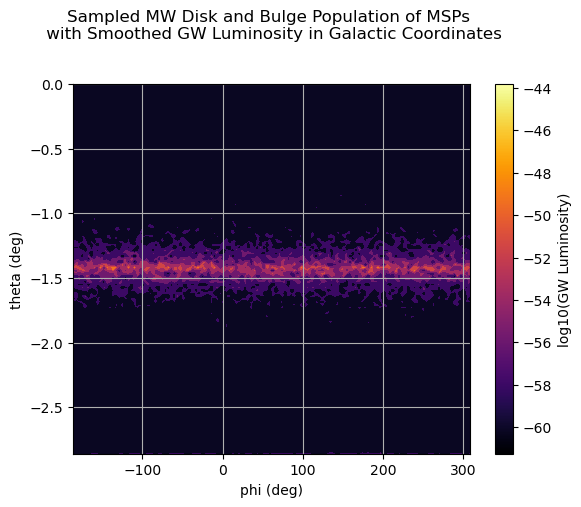

In [20]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the rectangular version, just to check things
from scipy.ndimage import gaussian_filter

print(np.min(np.log10(A_GW**2)))

#assuming that the angular resolution is 1 arcminute (width of gaussian is 0.01667 deg/2.91E-4 rad)
data1 = np.histogram2d(phi, theta, bins=130, weights = np.log10(A_GW**2))[0]
data2 = gaussian_filter(data1, sigma=0.01667)

plt.contourf(data2.T, cmap='inferno_r', extent = ((180/math.pi)*phi[0], (180/math.pi)*phi[-1], (180/math.pi)*theta[0], (180/math.pi)*theta[-1]))

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW)**2)), 
       np.max(np.log10((A_GW)**2))), cmap='inferno'), label = "log10(GW Luminosity)")


#plt.colorbar(label = "GW Luminosity")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with Smoothed GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("phi (deg)")
plt.ylabel("theta (deg)")

plt.show()

<Figure size 640x480 with 0 Axes>

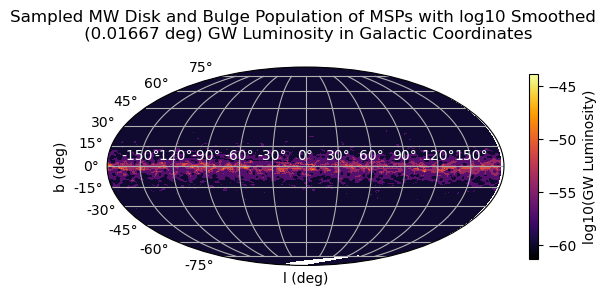

[4.82248893e-23 3.17683663e-23 1.23332759e-22]


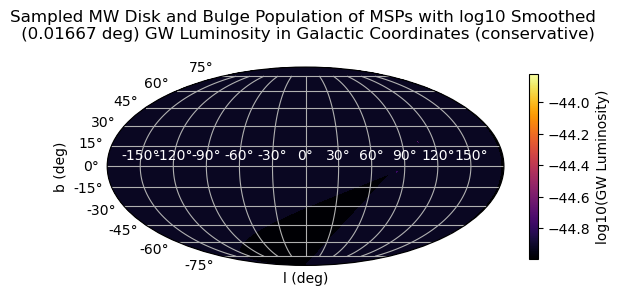

50


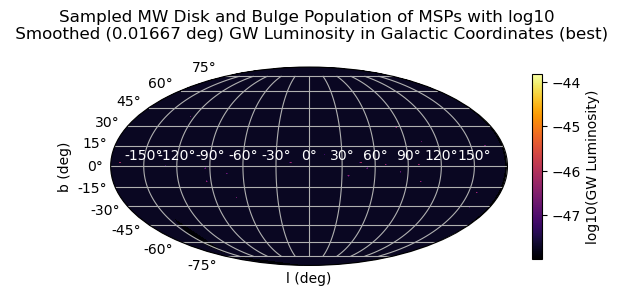

In [22]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the mollweide projection one!
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

fig = plt.figure()

bin_number = 130
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

#plot with no sensitivity
data1 = np.histogram2d(phi, theta, bins=[lon_edges, lat_edges], weights = np.log10((A_GW**2)))[0]
#assuming that the angular resolution is 1 arcminute (width of gaussian is 0.01667 deg/2.91E-4 rad)
data2 = gaussian_filter(data1, sigma=0.01667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW)**2)), 
       np.max(np.log10((A_GW)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (0.01667 deg) GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#most conservative sensitivity (GEO)
A_GW_cons = A_GW[A_GW > 3e-23]
print(A_GW_cons)

data1 = np.histogram2d(phi[A_GW > 3e-23], theta[A_GW > 3e-23], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_cons**2)))[0]
#assuming that the angular resolution is 1 arcminute (width of gaussian is 0.01667 deg/2.91E-4 rad)
data2 = gaussian_filter(data1, sigma=0.01667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_cons)**2)), 
       np.max(np.log10((A_GW_cons)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (0.01667 deg) GW Luminosity in Galactic Coordinates (conservative)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'white'
plt.xticks(color = "white")

plt.show()

#second plot with best sensitivity (ET)
A_GW_opt = A_GW[A_GW > 1e-24]
print(A_GW_opt.size)

data1 = np.histogram2d(phi[A_GW > 1e-24], theta[A_GW > 1e-24], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_opt)**2))[0]
#assuming that the angular resolution is 1 arcminute (width of gaussian is 0.01667 deg/2.91E-4 rad)
data2 = gaussian_filter(data1, sigma=0.01667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_opt)**2)), 
       np.max(np.log10((A_GW_opt)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 \n Smoothed (0.01667 deg) GW Luminosity in Galactic Coordinates (best)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

<Figure size 640x480 with 0 Axes>

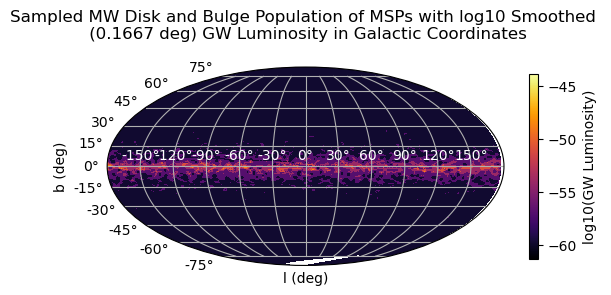

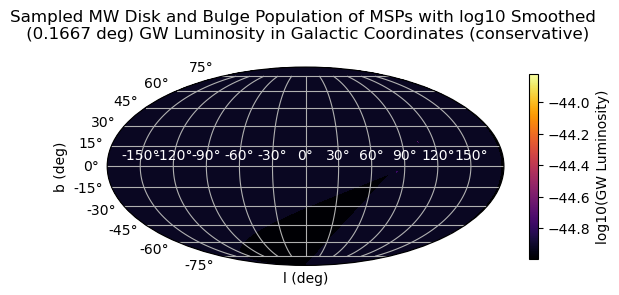

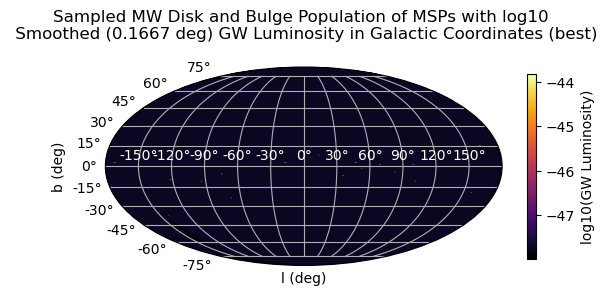

In [23]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the mollweide projection one!
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

fig = plt.figure()

bin_number = 130
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

#plot with no sensitivity
data1 = np.histogram2d(phi, theta, bins=[lon_edges, lat_edges], weights = np.log10((A_GW**2)))[0]
#assuming that the angular resolution is 10 arcminutes 
data2 = gaussian_filter(data1, sigma=0.1667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW)**2)), 
       np.max(np.log10((A_GW)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (0.1667 deg) GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#most conservative sensitivity (GEO)
data1 = np.histogram2d(phi[A_GW > 3e-23], theta[A_GW > 3e-23], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_cons)**2))[0]
#assuming that the angular resolution is 10 arcminutes
data2 = gaussian_filter(data1, sigma=0.1667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_cons)**2)), 
       np.max(np.log10((A_GW_cons)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (0.1667 deg) GW Luminosity in Galactic Coordinates (conservative)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#second plot with best sensitivity (ET)
data1 = np.histogram2d(phi[A_GW > 1e-24], theta[A_GW > 1e-24], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_opt)**2))[0]
#assuming that the angular resolution is 10 arcminutes
data2 = gaussian_filter(data1, sigma=0.1667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_opt)**2)), 
       np.max(np.log10((A_GW_opt)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 \n Smoothed (0.1667 deg) GW Luminosity in Galactic Coordinates (best)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

<Figure size 640x480 with 0 Axes>

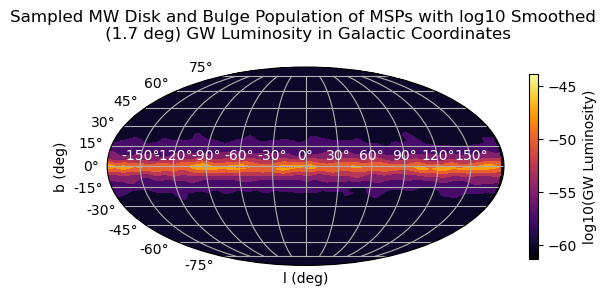

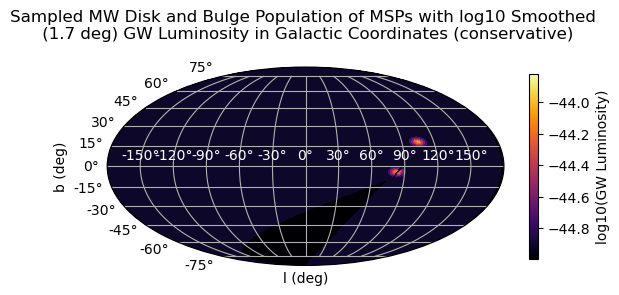

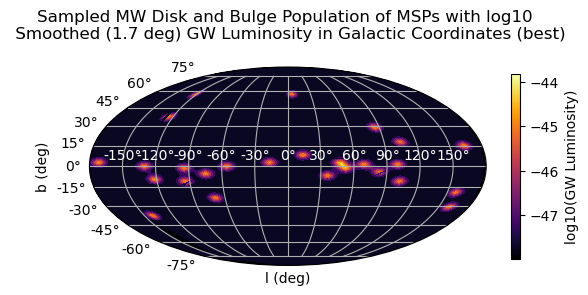

In [24]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the mollweide projection one!
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

fig = plt.figure()

bin_number = 130
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

#plot with no sensitivity
data1 = np.histogram2d(phi, theta, bins=[lon_edges, lat_edges], weights = np.log10((A_GW**2)))[0]
#assuming that the angular resolution is 1.7 deg
data2 = gaussian_filter(data1, sigma=1.7) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW)**2)), 
       np.max(np.log10((A_GW)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (1.7 deg) GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#most conservative sensitivity (GEO)
data1 = np.histogram2d(phi[A_GW > 3e-23], theta[A_GW > 3e-23], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_cons)**2))[0]
#assuming that the angular resolution is 1.7 deg
data2 = gaussian_filter(data1, sigma=1.7) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_cons)**2)), 
       np.max(np.log10((A_GW_cons)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (1.7 deg) GW Luminosity in Galactic Coordinates (conservative)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#second plot with best sensitivity (ET)
data1 = np.histogram2d(phi[A_GW > 1e-24], theta[A_GW > 1e-24], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_opt)**2))[0]
#assuming that the angular resolution is 1.7 deg
data2 = gaussian_filter(data1, sigma=1.7) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_opt)**2)), 
       np.max(np.log10((A_GW_opt)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 \n Smoothed (1.7 deg) GW Luminosity in Galactic Coordinates (best)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

<Figure size 640x480 with 0 Axes>

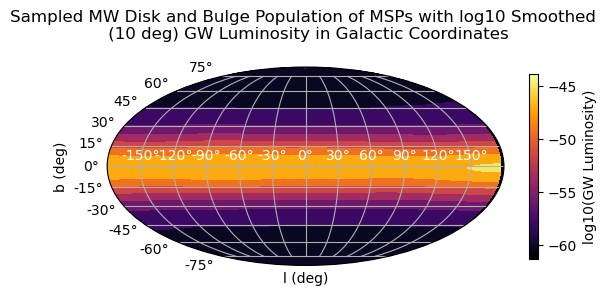

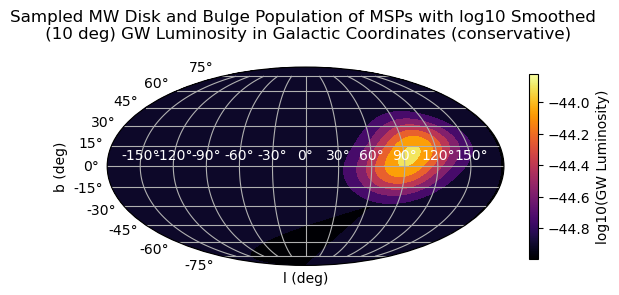

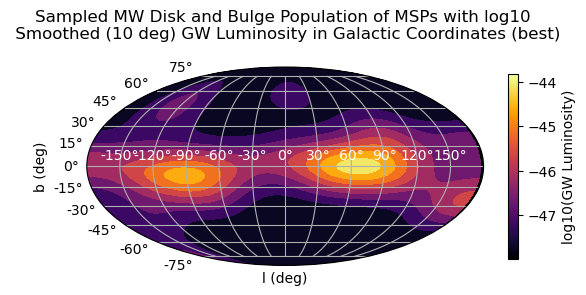

In [25]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the mollweide projection one!
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

fig = plt.figure()

bin_number = 130
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

#plot with no sensitivity
data1 = np.histogram2d(phi, theta, bins=[lon_edges, lat_edges], weights = np.log10((A_GW**2)))[0]
#assuming that the angular resolution is 10 deg
data2 = gaussian_filter(data1, sigma=10) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW)**2)), 
       np.max(np.log10((A_GW)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (10 deg) GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#most conservative sensitivity (GEO)
data1 = np.histogram2d(phi[A_GW > 3e-23], theta[A_GW > 3e-23], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_cons)**2))[0]
#assuming that the angular resolution is 10 deg
data2 = gaussian_filter(data1, sigma=10) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_cons)**2)), 
       np.max(np.log10((A_GW_cons)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (10 deg) GW Luminosity in Galactic Coordinates (conservative)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#second plot with best sensitivity (ET)
data1 = np.histogram2d(phi[A_GW > 1e-24], theta[A_GW > 1e-24], bins=[lon_edges, lat_edges], weights = np.log10((A_GW[A_GW > 1e-24])**2))[0]
#assuming that the angular resolution is 10 deg
data2 = gaussian_filter(data1, sigma=10) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW[A_GW > 1e-24])**2)), 
       np.max(np.log10((A_GW[A_GW > 1e-24])**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 \n Smoothed (10 deg) GW Luminosity in Galactic Coordinates (best)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

In [21]:
#look at GW detector constraints on signal and number of MSPs
A_GW_cons = A_GW[A_GW > 3e-23]
print("A_GW_cons size = ")
print(A_GW_cons.size)
print("Cons. ave. GW freq. = ")
freq_sample2 = freq_sample[np.isfinite(init_A_GW)]
print(np.average(freq_sample2[A_GW > 3e-23]))
print("Cons. ave. GW lum. =")
print(np.average((A_GW_cons**2)))

A_GW_opt = A_GW[A_GW > 1e-24]
print("A_GW_opt size = ")
print(A_GW_opt.size)
print("Opt. ave. GW freq. = ")
print(np.average(freq_sample2[A_GW > 1e-24]))
print("Opt. ave. GW lum. =")
print(np.average((A_GW_opt**2)))

A_GW_cons size = 
3
Cons. ave. GW freq. = 
414.02947404662626
Cons. ave. GW lum. =
6.181946138206196e-45
A_GW_opt size = 
50
Opt. ave. GW freq. = 
330.64646310288686
Opt. ave. GW lum. =
4.035207511440294e-46


Ave. Num. MSPS Cons. = 
2.34
Ave. Freq. Cons. = 
391.8889583333333
Ave. Lum. Cons. = 
1.05450325e-42


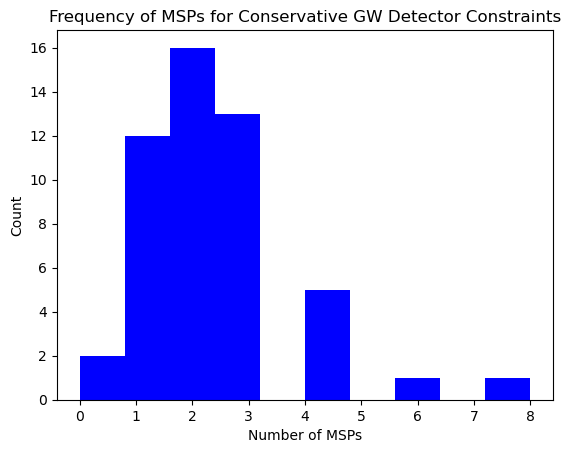

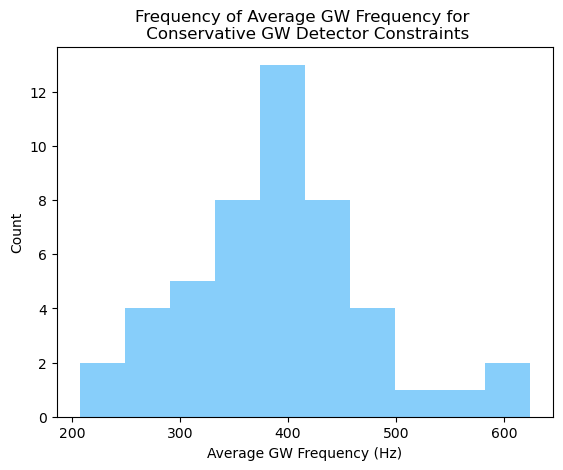

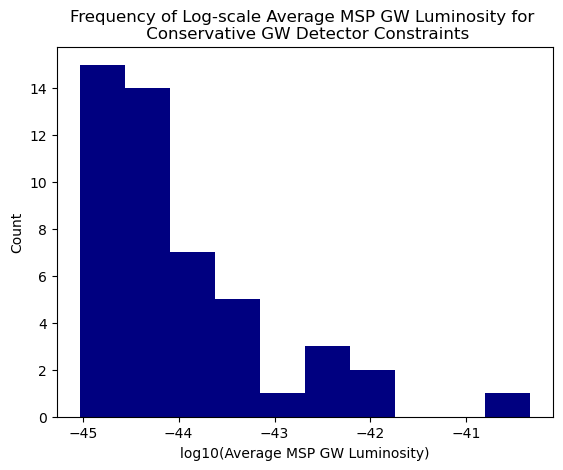

Ave. Num. MSPS Opt. = 
57.04081632653061
Ave. Freq. Opt. = 
364.2912
Ave. Lum. Opt. = 
1.9954343999999997e-44


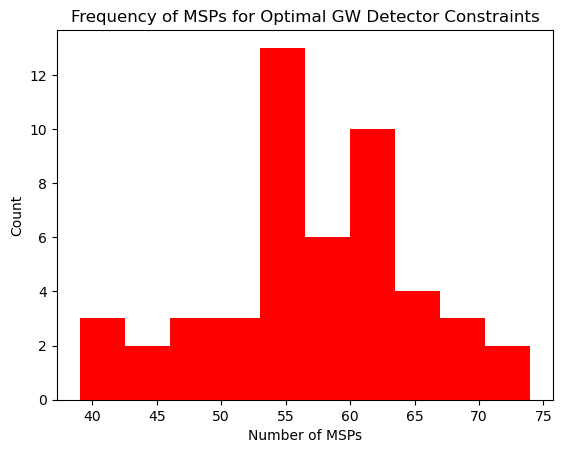

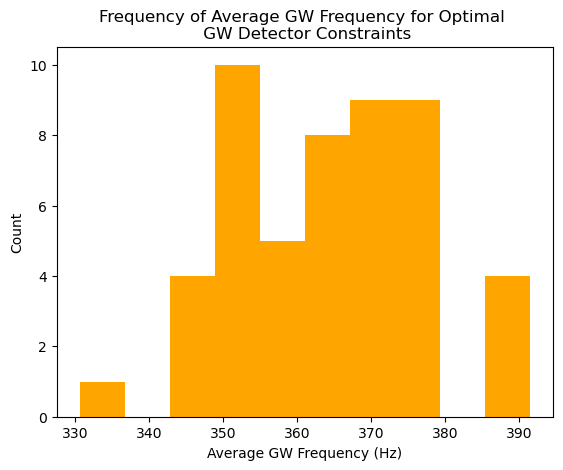

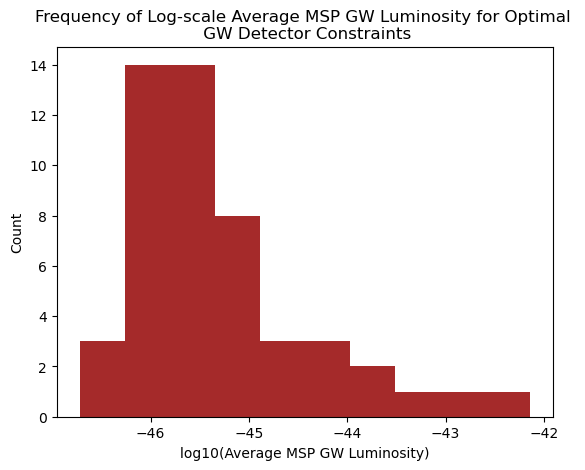

In [36]:
#make plots using the data obtained after 50 runs of the above cell (this took a while)

#for the conservative detector constraints:
num_MSPs_cons = [1, 3, 3, 2, 1, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 3, 1, 1, 2, 3, 1, 0, 1, 1, 4, 
                 3, 8, 2, 3, 4, 1, 4, 0, 1, 2, 3, 1, 2, 1, 2, 6, 2, 2, 4, 1, 2, 4, 2, 3, 3]
ave_freq_cons = [405.07, 526.40, 435.22, 389.28, 320.64, 233.44, 578.67, 290.96, 332.54, 
                 379.18, 401.45, 391.78, 341.88, 289.26, 411.60, 454.58, 435.86, 423.57, 
                 363.88, 340.20, 358.03, 465.11, 621.95, 451.60, 385.07, 288.44, 
                 410.69, 384.10, 426.40, 458.40, 349.23, 450.85, 399.02, 319.98, 
                 256.60, 467.87, 267.28, 207.15, 350.84, 310.44, 344.75, 329.60, 624.32, 
                 399.32, 407.17, 445.35, 471.62, 414.03]
ave_GW_lum_cons = [8.42e-45, 2.00e-45, 2.59e-45, 1.61e-43, 2.29e-45, 2.34e-44, 1.41e-42, 
                   3.33e-45, 1.34e-44, 5.52e-44, 5.07e-43, 2.54e-44, 1.60e-45, 3.11e-45, 
                   7.52e-45, 4.10e-45, 3.96e-45, 9.26e-46, 1.85e-44, 2.79e-44, 1.85e-45, 
                   1.54e-45, 4.63e-45, 2.29e-45, 9.80e-45, 8.77e-43, 2.28e-43, 
                   1.66e-45, 2.31e-44, 1.35e-45, 3.14e-45, 4.67e-41, 1.08e-45, 
                   3.98e-45, 4.00e-45, 3.05e-44, 2.03e-45, 6.95e-44, 2.59e-45, 1.92e-45, 
                   6.08e-45, 6.89e-45, 1.72e-45, 4.15e-45, 3.27e-43, 3.65e-45, 8.88e-45, 6.18e-45]

#print useful values:
print("Ave. Num. MSPS Cons. = ")
print(np.average(num_MSPs_cons))
print("Ave. Freq. Cons. = ")
print(np.average(ave_freq_cons))
print("Ave. Lum. Cons. = ")
print(np.average(ave_GW_lum_cons))

#now plot these as histograms
plt.hist(num_MSPs_cons, color = "blue")
plt.title("Frequency of MSPs for Conservative GW Detector Constraints")
plt.xlabel("Number of MSPs")
plt.ylabel("Count")
plt.show()

plt.hist(ave_freq_cons, color = "lightskyblue")
plt.title("Frequency of Average GW Frequency for \n Conservative GW Detector Constraints")
plt.xlabel("Average GW Frequency (Hz)")
plt.ylabel("Count")
plt.show()

plt.hist(np.log10(ave_GW_lum_cons), color = "navy")
plt.title("Frequency of Log-scale Average MSP GW Luminosity for \n Conservative GW Detector Constraints")
plt.xlabel("log10(Average MSP GW Luminosity)")
plt.ylabel("Count")
plt.show()

#for the optimal detector constraints:
num_MSPs_opt = [54, 62, 55, 40, 65, 63, 55, 67, 45, 57, 53, 59, 57, 55, 56, 61, 59, 42, 63, 69, 
                39, 55, 52, 47, 66, 74, 53, 61, 62, 52, 69, 61, 62, 64, 61, 56, 54, 49, 66, 43, 
                54, 48, 54, 73, 59, 55, 58, 61, 50]
ave_freq_opt = [350.26, 368.69, 373.80, 349.44, 348.77, 374.93, 391.58, 366.74, 352.76, 360.54, 
                351.03, 349.61, 359.72, 353.41, 373.33, 350.29, 366.05, 372.59, 367.17, 365.12, 
                345.23, 348.73, 368.91, 386.06, 370.25, 362.89, 363.62, 367.32, 373.05, 378.26, 
                370.64, 366.47, 352.60, 376.37, 358.90, 374.82, 377.44, 347.06, 366.29, 352.27, 
                355.75, 375.78, 350.10, 369.73, 369.01, 379.38, 386.22, 386.73, 358.20, 330.65]
ave_GW_lum_opt = [2.00e-46, 1.40e-46, 1.69e-46, 8.05e-45, 9.01e-47, 7.61e-46, 5.13e-44, 1.16e-46, 
                  9.12e-46, 2.93e-45, 1.91e-44, 8.90e-46, 1.32e-46, 1.28e-46, 4.40e-46, 2.72e-46, 
                  9.77e-47, 9.16e-47, 6.41e-46, 1.25e-45, 7.23e-47, 1.90e-47, 5.66e-47, 1.13e-46, 
                  1.73e-46, 4.26e-46, 1.32e-43, 7.53e-45, 1.89e-46, 1.83e-45, 6.84e-47, 2.30e-46, 
                  3.63e-47, 7.30e-43, 6.35e-47, 2.30e-46, 7.17e-45, 1.17e-45, 7.30e-47, 2.14e-45, 
                  4.39e-46, 1.17e-46, 2.65e-46, 5.42e-46, 4.77e-47, 1.84e-46, 2.38e-44, 1.59e-46, 
                  4.59e-46, 4.04e-46]

#print useful values:
print("Ave. Num. MSPS Opt. = ")
print(np.average(num_MSPs_opt))
print("Ave. Freq. Opt. = ")
print(np.average(ave_freq_opt))
print("Ave. Lum. Opt. = ")
print(np.average(ave_GW_lum_opt))

#now plot these as histograms
plt.hist(num_MSPs_opt, color = "red")
plt.title("Frequency of MSPs for Optimal GW Detector Constraints")
plt.xlabel("Number of MSPs")
plt.ylabel("Count")
plt.show()

plt.hist(ave_freq_opt, color = "orange")
plt.title("Frequency of Average GW Frequency for Optimal \n GW Detector Constraints")
plt.xlabel("Average GW Frequency (Hz)")
plt.ylabel("Count")
plt.show()

plt.hist(np.log10(ave_GW_lum_opt), color = "brown")
plt.title("Frequency of Log-scale Average MSP GW Luminosity for Optimal \n GW Detector Constraints")
plt.xlabel("log10(Average MSP GW Luminosity)")
plt.ylabel("Count")
plt.show()